In [1]:
import nibabel as nib
import numpy as np
import cv2
import os
import scipy
import sklearn
import matplotlib.pyplot as plt
import torch
import re
from itkwidgets import view,label_statistics
import itkwidgets
import torchvision
from sklearn.cluster import KMeans
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from skimage import data, exposure, img_as_float
import SimpleITK as sitk
import gui
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

from skimage import exposure, io, util
from skimage import color, morphology
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.segmentation import flood, flood_fill
import skimage.io as skio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import cv2
import numpy as np
import glob
import os
import cupy as cp
import cupyx.scipy.ndimage as ndimage

%matplotlib notebook

Failed to load image Python extension: Could not find module 'C:\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.


In [2]:
def matric_to_image_seq(matric, output_path='./Data/Output/'):
    count = 0
    image = matric[count,:,:]
    print("converting video to frames...")
    try:
        while image is not np.empty:
            fname = str(count)
            cv2.imwrite(os.path.join(output_path, fname + ".jpg"), np.uint8(image)*255)  # save frame as JPEG file
            count += 1
            image = matric[count]
            # print('Read a new frame: ', success)
    except:
        print("Done")
        
    print("total frames: ", count)


def load_image_seq(path_to_seq, file_name="", file_ext="jpg"):
    # load image sequence
    image_seq = []
    for idx , frame in enumerate(os.listdir(path_to_seq)):
        frame = Image.open(f'{path_to_seq}/{file_name}{idx}.{file_ext}')
        frame = np.array(frame)
        image_seq.append(frame)
    return np.array(image_seq)


In [12]:
def plot_hist(ax, data, title=None):
    # Helper function for plotting histograms
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    if title:
        ax.set_title(title)


def plot_comparison(original, filtered, filter_name, og_name = "original"):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title(og_name)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

def plot_comparison_loop(n):
    
    fig, axis_list = plt.subplots(ncols=n, figsize=(8, 4), sharex=True,
                                   sharey=True)
    return axis_list
    
def imshow(image, axis_list=None, title="Image #", n=0):
    
    if axis_list is None:
        axis_list = plot_comparison_loop(1)
        axis_list = [axis_list]
    axis_list[n].imshow(image, cmap=plt.cm.gray)
    axis_list[n].set_title(f'{title} #{n}')
    axis_list[n].axis('off')


def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)
        
def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image


<IPython.core.display.Javascript object>


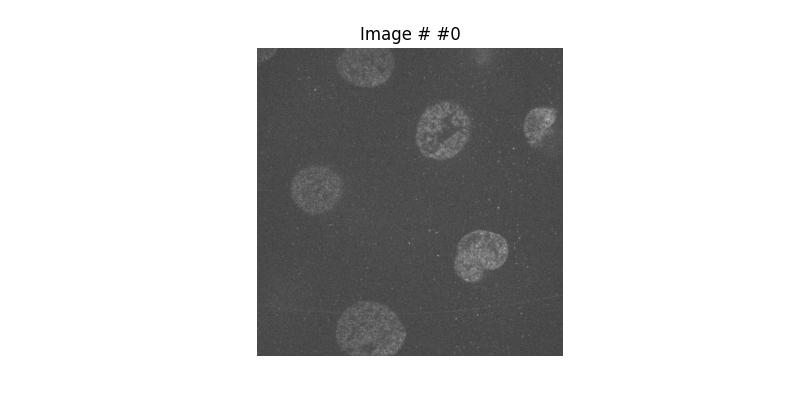

In [32]:
filename = "oblong/#3_h27#4_expgel_dapi_npc_h27/#3_tile1_DAPI.tif"
data = skio.imread("Data/" + filename, plugin="tifffile")
# plot_comparison(data[10][0],data[10][1],'Ch2','Ch1')
# data = remove_zero_pad(data[:,:,:])
imshow(data[10])

In [33]:
%%time
vmin, vmax = np.percentile(data, q=(1, 99))

clipped_data = exposure.rescale_intensity(
    data,
    in_range=(vmin, vmax),
    out_range=np.float32
)

equalized_data = exposure.equalize_hist(data)

equalized_clipped_data = exposure.equalize_hist(clipped_data)

Wall time: 32.5 s


In [16]:
# _, a = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
# plot_hist(a, equalized_clipped_data[32])

<IPython.core.display.Javascript object>


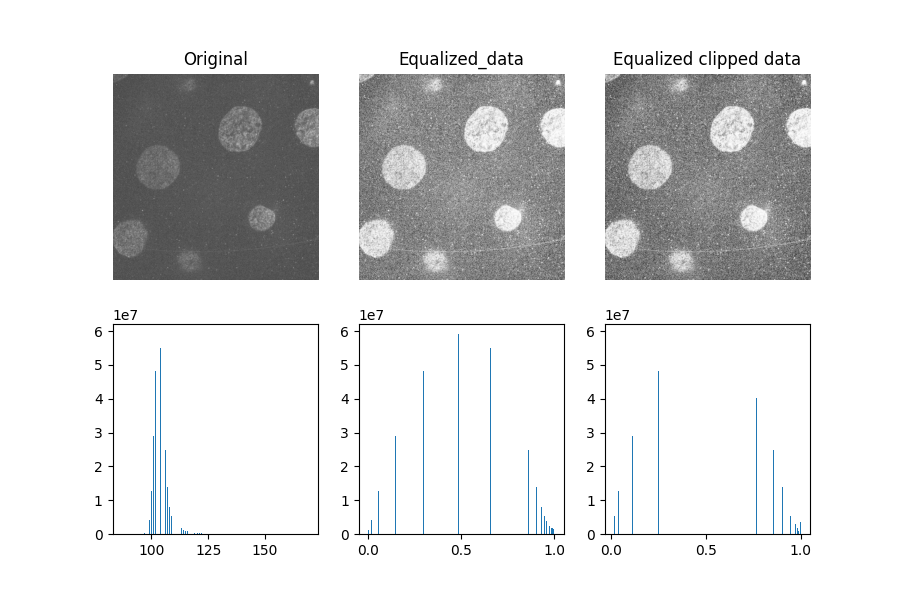

In [35]:
_, ((a, b, c), (d, e, f)) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
show_plane(a, data[32], title='Original')
show_plane(b, equalized_data[32], title=f'Equalized_data')
show_plane(c, equalized_clipped_data[32], title=f'Equalized clipped data')

plot_hist(d, data)
plot_hist(e, equalized_data)
plot_hist(f, equalized_clipped_data)

In [36]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()


In [37]:
%%time
from skimage.filters import gaussian, median
from skimage.morphology import ball

# n_median = 2
# smoothed_median = binary_data
# axis_list = plot_comparison_loop(n_median+1)
# imshow(smoothed_median[32], axis_list, 'Original mask', 0)
# for item in range(n_median):
#     smoothed_median = median(smoothed_median, ball(8))
#     imshow(smoothed_median[32], axis_list, 'median mask', item+1)  

    
import cupy as cp
import cupyx.scipy.ndimage as ndimageg
n_median = 3
smoothed_median_g = cp.asarray(equalized_clipped_data)
for item in range(n_median):
    smoothed_median_g = ndimageg.median_filter(smoothed_median_g, (8,8,3))
    smoothed_median_g = ndimageg.gaussian_filter(smoothed_median_g, 3)
smoothed_median = smoothed_median_g.get()

Wall time: 1min 48s


In [38]:
itkwidgets.compare(equalized_clipped_data,smoothed_median)
# imshow(smoothed_median[60])

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

<IPython.core.display.Javascript object>


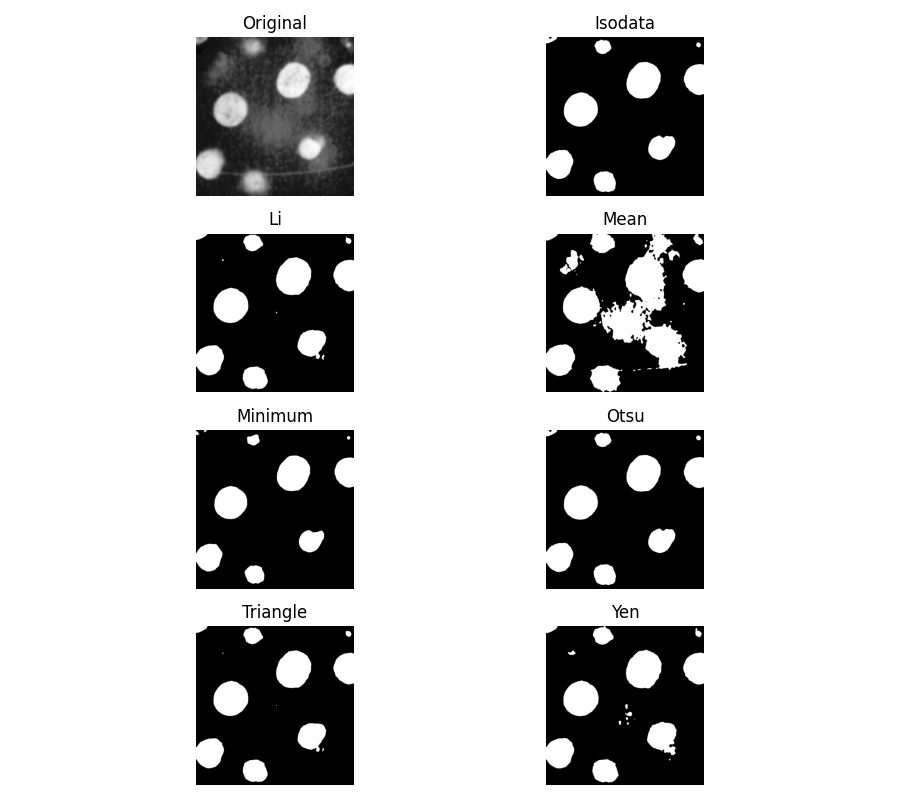

Wall time: 1min 12s


In [48]:
%%time

from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(smoothed_median[32], figsize=(9, 8), verbose=False)
plt.show()
from skimage.filters import threshold_isodata
import cupyx.scipy.ndimage as ndimage

thresh = threshold_isodata(smoothed_median)
thersholded_image = cp.asarray(smoothed_median > thresh)
thersholded_closed = ndimage.binary_fill_holes(thersholded_image).get()
del thersholded_image

In [42]:
view(np.uint8(thersholded_image))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

<IPython.core.display.Javascript object>


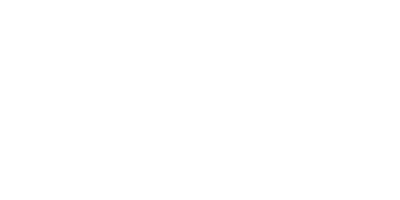

Wall time: 1min 23s


In [46]:
%%time
# from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
#                                 white_tophat)

# closed = closing(image_eroded_two,ball(5))
# plot_comparison(image_eroded_two[32], closed[32], 'closing')

# opened = opening(closed,ball(5))
# plot_comparison(closed[32], opened[32], 'opening')

# matric_to_image_seq(opened,"./oblong_gel_ddw_sub_binary/")
closed  = cp.asarray(thersholded_image)
ball3 = cp.asarray(ball(3))
thersholded_closed = ndimage.binary_fill_holes(closed)
dialted = ndimage.binary_dilation(closed, ball3, 2,brute_force=True)
closed = ndimage.binary_closing(dialted, ball3, 2, border_value=1,brute_force=True)
closed = closed.get()
thersholded_closed = thersholded_closed.get()
plot_comparison(thersholded_closed[32], closed[32], 'closing')
# view(np.uint8(closed))

In [45]:
%%time
import cupyx.scipy.ndimage as ndimage
from skimage.morphology import ball
from scipy import ndimage as ndi
from ipywidgets import IntProgress
from IPython.display import display
import tensorflow as tf
import tensorflow_addons as tfa

max_count = 3

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

# thersholded_image = cp.asarray(thersholded_image)
# dist_transform = ndimage.distance_transform_edt(thersholded_image)
dist_transform = tfa.image.euclidean_dist_transform(np.uint8(closed))
f.value += 1
seeds = dist_transform > np.percentile(dist_transform,99)
f.value += 1
# Finding sure foreground area
f.value += 1
view(np.uint8(seeds))

IntProgress(value=0, max=3)

Wall time: 5.57 s


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [14]:
%%time
from skimage.measure import label
from skimage import measure, util
from skimage import data, util
from skimage.measure import label, regionprops_table
import pandas as pd

label_img = label(seeds, connectivity=seeds.ndim)
props = regionprops_table(label_img, thersholded_closed, cache=True, properties=['label' , 'euler_number','area'])


propsdf = pd.DataFrame(props)
propsdf = propsdf.sort_values(by=['area'], ascending=False)
# display(propsdf.head(50))
print(propsdf.size)
size_th = 10
print(size_th)

condition = (props['area'] > size_th )
print(np.sum(condition))
# zero out labels not meeting condition
input_labels = props['label']
output_labels = input_labels * condition
filtered_lab_image = util.map_array(
    label_img, input_labels, output_labels
)
seeds = filtered_lab_image > 0;
# view(label_image=np.uint8(label_img))

63
10
19
Wall time: 2.1 s


<IPython.core.display.Javascript object>


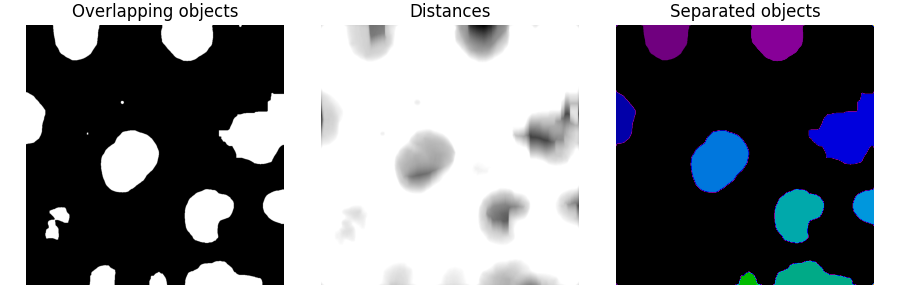

Wall time: 25.1 s


Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_label_image=<itk.itk…

In [15]:
%%time
from skimage.segmentation import watershed

labels = watershed(-dist_transform.numpy(), filtered_lab_image, mask=thersholded_closed)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(thersholded_image[32], cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-dist_transform.numpy()[32], cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels[32], cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show()
labels_with_seed = np.uint8(labels + filtered_lab_image*3)
view(label_image=labels_with_seed)

In [37]:
data = skio.imread("Data/" + filename , plugin="tifffile")
shape = np.array(data.shape)
shape[1] = shape[1] + 1
dataout = np.zeros(shape)
dataout[:,0,:,:] = data[:,0,:,:]
dataout[:,1,:,:] = data[:,1,:,:]
dataout[:,2,:,:] = np.uint16(labels*30)

skio.imsave("Data/" + "segmented_" +filename,dataout)

In [45]:
view(smoothed_median)

cell = smoothed_median[:,720:880,750:880]
cellb = thersholded_closed[:,720:800,800:880]
celld = data[:,720:800,800:880]
view(np.uint8(celld))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [29]:
# %%time
cell = smoothed_median[:,420:600,450:660]
cellb = thersholded_closed[:,420:600,450:660]
celld = data[:,420:600,450:660]
view(np.uint8(cell))

import morphsnakes as ms


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

init_ls = ms.circle_level_set(cell.shape, (80, 120, 69), 10)
# view(np.uint8(cellb+init_ls*40))

segmented = ms.morphological_chan_vese(celld, iterations=200,
                           init_level_set=init_ls,
                           smoothing=1, lambda1=1, lambda2=2)

view(celld , label_image = np.uint8(segmented)*10)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [30]:
view(np.uint8(segmented))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [22]:
import morphsnakes as ms

img = np.load("Data/images/confocal.npy")
view(img)
# Initialization of the level-set.
init_ls = ms.circle_level_set(img.shape, (30, 50, 80), 25)
view(np.uint8(init_ls*3 + img))

# Morphological Chan-Vese (or ACWE)
segmented = ms.morphological_chan_vese(img, iterations=150,
                           init_level_set=init_ls,
                           smoothing=1, lambda1=1, lambda2=2)
view(np.uint8(segmented))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [42]:
%%time
from skimage.measure import label
from skimage import measure, util

props = regionprops_table(labels, thersholded_image, cache=True, properties=['label' , 'solidity','area_convex'])
display(pd.DataFrame(props).sort_values(by=['solidity'], ascending=False))

condition = (props['solidity'] < 0.75 ) 
print(np.sum(condition))
# zero out ]labels not meeting condition
input_labels = props['label']
output_labels = input_labels * condition
filtered_lab_image = util.map_array( 
    labels, input_labels, output_labels
)
# view(label_image=np.uint8(filtered_lab_image))

,label,solidity,area_convex
28,31,0.970042,1335516
7,8,0.965192,445731
2,3,0.957921,1306227
30,33,0.956989,765432
16,18,0.955181,683662
18,20,0.953819,565792
8,9,0.952823,1004118
9,10,0.952497,233481
19,21,0.951637,1289026
23,26,0.950240,1234539


5
Wall time: 16min 1s


In [44]:
import skimage.transform as st
max_count = 6
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

(z, h, w) = np.shape(filtered_lab_image)
filtered_lab_image_binary = st.resize(filtered_lab_image, (z, h/3, w/3))
f.value += 1
dist_transform = ndi.distance_transform_edt(filtered_lab_image_binary)
f.value += 1
seeds_non_solid = dist_transform > np.percentile(dist_transform,99.9)
f.value += 1

filtered_lab_image_binary = st.resize(filtered_lab_image_binary, (z, h, w))
seeds_non_solid = st.resize(seeds_non_solid, (z, h, w))
dist_transform = st.resize(dist_transform, (z, h, w))
# Finding sure foreground area
f.value += 1
labeled_seeds= label(seeds_non_solid, connectivity=seeds.ndim)
f.value += 1
labels_connected = watershed(-dist_transform, labeled_seeds, mask=filtered_lab_image_binary)
f.value += 1
itkwidgets.compare(np.uint8(labels_connected*5),np.uint8(filtered_lab_image))

IntProgress(value=0, max=6)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [46]:
seeds = seeds + seeds_non_solid

label_img = label(seeds, connectivity=seeds.ndim)
# props = regionprops_table(label_img, binary_data, cache=True, properties=['label' , 'solidity','area'])
labels_complete = watershed(-dist_transform, label_img, mask=thersholded_image)


view(label_image=np.uint8(labels_complete))

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_label_image=<itk.itk…

In [44]:
import numpy as np
from skimage.segmentation import clear_border

labels_removed_border = clear_border(labels_complete)
props = regionprops_table(labels_removed_border, binary_data, cache=True, properties=['label' , 'solidity','area_convex'])
view(label_image=np.uint8(labels_removed_border))
propsdf = pd.DataFrame(props)
display(propsdf)

,label,solidity,area_convex
0,1,0.898650,757800
1,2,0.639780,3243825
2,3,0.783298,2696023
3,4,0.685176,2280888
4,5,0.955897,1129300
5,6,0.959018,1074801
6,7,0.654564,2220800
7,8,0.930043,1150829
8,9,0.582784,1834810
9,10,0.902490,813427


In [45]:
view(label_image=np.uint8(labels_removed_border))

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_label_image=<itk.itk…

In [46]:
from ipywidgets import IntProgress
from IPython.display import display

max_count = 4

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

labels_image = sitk.GetImageFromArray(labels_removed_border)
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(labels_image)
f.value += 1
intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(labels_image,img) 
f.value += 1
bacteria_labels = shape_stats.GetLabels()
bacteria_volumes = [shape_stats.GetPhysicalSize(label) for label in bacteria_labels] 
f.value += 1

bacteria_labels_volume_sorted = [label for _,label in sorted(zip(bacteria_volumes, bacteria_labels))]

resampler = sitk.ResampleImageFilter()
aligned_image_spacing = [10,10,10] #in nanometers
obb_imgs = [];
f.value += 1

IntProgress(value=0, max=4)

NameError: name 'img' is not defined

In [ ]:
print(bacteria_labels_volume_sorted)
binary_data_image = sitk.GetImageFromArray(binary_data)
tunnels_image = sitk.GetImageFromArray(cell_tunnels)
caseing_image = sitk.GetImageFromArray(cell_caseing)
num_images = len(propsdf) # number of bacteria images we want to display
obb_imgs_all = [[],[],[]]
data_imgs = [binary_data_image,tunnels_image,caseing_image]
for data_img, obb_imgs in zip(data_imgs, obb_imgs_all):
    for label in bacteria_labels_volume_sorted[0:num_images]:
        aligned_image_size = [ int(np.ceil(shape_stats.GetOrientedBoundingBoxSize(label)[i]/aligned_image_spacing[i])) for i in range(3) ]
        direction_mat = shape_stats.GetOrientedBoundingBoxDirection(label)
        aligned_image_direction = [direction_mat[0], direction_mat[3], direction_mat[6], 
                                   direction_mat[1], direction_mat[4], direction_mat[7],
                                   direction_mat[2], direction_mat[5], direction_mat[8] ] 
        resampler.SetOutputDirection(aligned_image_direction)
        resampler.SetOutputOrigin(shape_stats.GetOrientedBoundingBoxOrigin(label))
        resampler.SetOutputSpacing(aligned_image_spacing)
        resampler.SetSize(aligned_image_size)
        
        obb_img = resampler.Execute(data_img)
        # Change the image axes order so that we have a nice display.
        obb_img = sitk.PermuteAxes(obb_img,[2,1,0])
        obb_img = sitk.GetArrayFromImage(obb_img)
        obb_imgs.append(obb_img)
        print(np.array(obb_img).shape)

In [ ]:
view(obb_imgs_all[0][2])

In [ ]:
import tifffile
save_num = 0
for i in range(len(obb_imgs_all[0])):
    save_num = i
    x,y,z = obb_imgs_all[0][save_num].T.shape
    export_tiff = np.zeros([x,y,3,z])
    export_tiff[:,:,0,:] = obb_imgs_all[0][save_num].T
    export_tiff[:,:,1,:] = obb_imgs_all[1][save_num].T
    export_tiff[:,:,2,:] = obb_imgs_all[2][save_num].T

    tifffile.imwrite(f'cell_{save_num}.tif', export_tiff.T)
    print(export_tiff.T.shape)

In [10]:
# matric_to_image_seq(labels_complete,"./Data/Labeled/oblong_gel_ddw_sub/")
labels_complete = load_image_seq("./Data/Labeled/oblong_gel_ddw_sub")
labels_complete_img = sitk.GetImageFromArray(data)

In [91]:
view(equalized_clipped_data,
              label_image=np.uint8(labels_complete),
              label_image_blend=0.8)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, label_image_blend=0.8, point_sets=[], render…